Each user has reviewed some number of recipes, and those recipes each require certain ingredients. A user's "pantry" is the set of ingredients that have appeared in some recipe reviewed by that author. 

The goal of this notebook is to determine whether a user's pantry can be used to predict their ratings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
revdf = pd.read_pickle('data/reviewsred.pk')
recdf = pd.read_pickle('data/rec_ingredients.pk')

We've imported two dataframes: 'revdf', which contains ratings, and 'recdf', which contains recipes and their ingredients.

Our goal is to understand the authors of the reviews, so we're going to collect data from the dataframes and group it by author:

In [3]:
# We start by obtaining the list of reviewers from the dataframe. 
# It will be important that we have an ordered version of that list with no repeats.
author_ids = list(set(revdf['AuthorId'].values))
# We group data by author. We are interested in two types of data: 
#author_data[author]['Ratings'] returns a dictionary with ratings data,
#autor_data[author]['Ingredients'] returns a list of the ingredients used by that author. 
# Note that the list contains repetitions: the number of occurences of an ingredient is equal to the number of times the reviewer
# has used that ingredient. 
author_data = {author_id:{'Ratings':{},'Ingredients':[]} for author_id in author_ids}
for review_index in revdf.index:
    author_id = revdf['AuthorId'][review_index]
    recipe_id = revdf['RecipeId'][review_index]
    author_data[author_id]['Ratings'][recipe_id]=revdf['Rating'][review_index]
    author_data[author_id]['Ingredients']+=(recdf['RecipeIngredientParts'][recipe_id])

# Once all of the data has been collected, we can process it further.

# We're going to renormalize our ratings so that the mean rating for each author is 0 and the standard deviation is 1.
# We also record the mean, the standard deviation and the number of reviews for each author.
for author_id in author_data:
    ratings = list(author_data[author_id]['Ratings'].values())
    avg = np.mean(ratings)
    std = np.std(ratings)
    author_data[author_id]['No_ratings'] = len(ratings)
    author_data[author_id]['Average_rating'] = avg
    author_data[author_id]['Std_rating'] = std
    author_data[author_id]['Normalized_ratings'] = {recipe_id:(author_data[author_id]['Ratings'][recipe_id]-avg)/std 
                                                    for recipe_id in author_data[author_id]['Ratings']}

# We construct dictionaries that whose keys are the ingredients in the user's pantry,
# and the values record the number of times each ingredient is used.
# This will be more useful than the list we currently have.
for author_id in author_data:
    ingredients_a = author_data[author_id]['Ingredients']
    ingredient_counts = {ingredient:0 for ingredient in ingredients_a}
    for ingredient in ingredients_a:
        ingredient_counts[ingredient]+=1
    author_data[author_id]['Ingredient_counts']=ingredient_counts

We have over 40,000 unique reviewers, and we want to do some exploratory analysis involving pairs of reviewers.
There are far too many pairs of reviewers to choose from, so we're going to restrict attention to a small sample of reviewers.

To ensure we have a subset with lots of reviews, we're going to simply pick the authors with at least $n$ reviews (explicitly $n = 100$,
which gives us 1724 authors).

In [4]:
auth100 = [a for a in author_ids if author_data[a]['No_ratings']>99]

Now, for each pair of reviewers, we compute the set of recipes reviewed by both reviewers. If that intersection is nonempty, we record the pair and the intersection in a dictionary for subsequent use.

The keys of this dictionary are the pairs (author1, author2) consisting of pairs of authors that have reviewed at least one common recipe.
The value associated to that pair is the nonempty set of recipeids of recipes reviewed by both.

In [5]:
auth100pairs = {}
for i in range(len(auth100)-1):
    author_id1 = auth100[i]
    recipe_ids1 = set(author_data[author_id1]['Normalized_ratings'].keys())
    for j in range(i+1,len(auth100)):
        author_id2 = auth100[j]
        recipe_ids2 = set(author_data[author_id2]['Normalized_ratings'].keys())
        if len(recipe_ids1.intersection(recipe_ids2))>0:
            auth100pairs[(author_id1,author_id2)] = list(recipe_ids1.intersection(recipe_ids2))

Given two authors, we want to quantify:
* How similar the authors' pantries are.
* How similar the authors reviews are.

I've written down functions that attempt to do that:
* The pantry similarity is going to be a number between 0, 1: similarity is 0 if the pantries are disjoint and similarity is 1 if they're equal. The closer to 1 the score is, the more similar the pantries.
* To compare ratings, we're only going to look at the set of recipes reviewed by both authors. Each author's reviews of those recipes can be encoded as a vector; we're going to compute the cosine similarity of those vectors to obtain a number between -1 and 1.

In [11]:
def pantry_similarity(pair):
    a0 = pair[0]
    a1 = pair[1]
    rijs = auth100pairs[pair]
    pantry0 = set(author_data[a0]['Ingredients'])
    pantry1 = set(author_data[a1]['Ingredients'])
    return len(pantry0.intersection(pantry1))/len(pantry0.union(pantry1))

def rating_similarity(pair):
    a0 = pair[0]
    a1 = pair[1]
    rijs = auth100pairs[pair]
    if len(rijs)==0:
        return 0
    ratings0 = author_data[a0]['Normalized_ratings']
    ratings1 = author_data[a1]['Normalized_ratings']
    dotprod = 0
    len0 = 0
    len1 = 0
    for ri in rijs:
        r0 = ratings0[ri]
        r1 = ratings1[ri]
        dotprod+=r0*r1
        len0+=r0*r0
        len1+= r1*r1
    sim = dotprod/(np.sqrt(len0*len1))
    return sim

In [15]:
len(auth100pairs)

1064641

In [13]:
pairlist100 = [pair for pair in auth100pairs if len(auth100pairs[pair])>100]
pairlist50 = [pair for pair in auth100pairs if len(auth100pairs[pair])>50]
pairlist10 = [pair for pair in auth100pairs if len(auth100pairs[pair])>10]

In [18]:
pantry_rating_m10 = np.array([[pantry_similarity(pair),rating_similarity(pair)] for pair in pairlist10])
pantry_rating_m100 = np.array([[pantry_similarity(pair),rating_similarity(pair)] for pair in pairlist100])

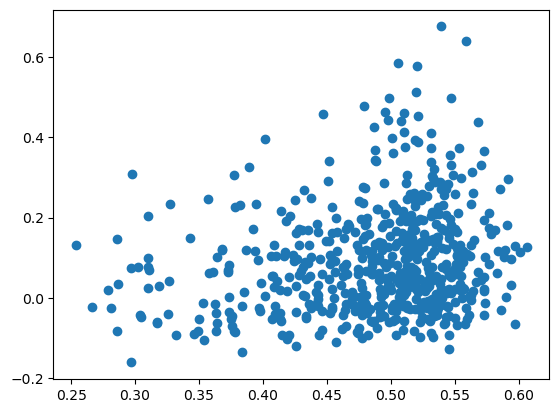

In [21]:
plt.scatter(pantry_rating_m100[:,0],pantry_rating_m100[:,1])
plt.show()

## Observations
* If we restrict to pairs authors with lots of recipes in common, and the authors have reviewed those recipes similarly, then they probably have similar pantries.
* The converse is false, however: just because two authors have lots of recipes in common and they have a similar pantry, the ratings vectors could be orthogonal.

## Next steps
* Experiment with other pantry similarity scores
* Experiment with other notions of similarity between users (e.g. nutrition, recipe difficulty)